# SpecAugment with TorchAudio
by [Zach Caceres](https://github.com/zcaceres) and [Jenny Cai](https://github.com/qcai2002)

This notebook feature a Pytorch implementation of the data augmentation techniques in [SpecAugment](https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html) by Google Brain.

The techniques are:
- Time Warp
- Frequency Mask
- Time Mask

SpecAugment reports that Frequency Mask and Time Mask were the most effective augmentations and less computationally expensive than Time Warp. We included Time Warp for completeness.

### Prerequisites
Be sure you've run `install.sh` before running this notebook!

### Setup

In [32]:
#Export
from pathlib import Path
from fastai.vision import Image
from IPython.display import Audio
import mimetypes
import torchaudio
import matplotlib.pyplot as plt
import torch
import fire
from torchaudio import transforms

This converts our implementation of `sparse_image_warp` into a Python file we can import.

In [33]:
%%sh
python notebook2script.py SparseImageWarp.ipynb

Converted SparseImageWarp.ipynb to nb_SparseImageWarp.py


In [34]:
from exp.nb_SparseImageWarp import sparse_image_warp

## Loading Audio

In [35]:
AUDIO_EXTENSIONS = tuple(str.lower(k) for k,v in mimetypes.types_map.items() 
                         if v.startswith('audio/'))

Let's check out our sample wav file (a snippet of Bach).

In [36]:
sample = Path('./party-crowd.wav')

In [37]:
def load_audio(p):
    return torchaudio.load(p)

In [38]:
def check_audio(p):
    sig,sr = load_audio(p)
    display(Audio(data=sig, rate=sr))
check_audio(sample)

## AudioData Class

We'll use a simple AudioData class as our atomic unit for audio. This class is borrowed from [fastai-audio](https://github.com/zcaceres/fastai-audio)

In [41]:
class AudioData:
    '''Holds basic information from audio signal'''
    def __init__(self, sig, sr=16000): 
        self.sig = sig.reshape(-1) # We want single dimension data
        self.sr = sr

    @classmethod
    def load(cls, fileName, **kwargs):
        p = Path(fileName)
        if p.exists() & str(p).lower().endswith(AUDIO_EXTENSIONS):
            signal,samplerate = torchaudio.load(str(fileName))
            return AudioData(signal,samplerate)
        raise Exception(f"Error while processing {fileName}: file not found or does not have valid extension: {AUDIO_EXTENSIONS}")

In [42]:
audio = AudioData.load(sample)

## Wav to (Mel)Spectrogram

We'll use an undocumented SPEC2DB class from `torchaudio` to make a Melspectrogram.

In [43]:
from torch.autograd import Variable

def _check_is_variable(tensor):
    if isinstance(tensor, torch.Tensor):
        is_variable = False
        tensor = Variable(tensor, requires_grad=False)
    elif isinstance(tensor, Variable):
        is_variable = True
    else:
        raise TypeError("tensor should be a Variable or Tensor, but is {}".format(type(tensor)))

    return tensor, is_variable

class SPEC2DB(object):
    """Turns a spectrogram from the power/amplitude scale to the decibel scale.

    Args:
        stype (str): scale of input spectrogram ("power" or "magnitude").  The
            power being the elementwise square of the magnitude. default: "power"
        top_db (float, optional): minimum negative cut-off in decibels.  A reasonable number
            is -80.
    """
    def __init__(self, stype="power", top_db=None):
        self.stype = stype
        self.top_db = -top_db if top_db > 0 else top_db
        self.multiplier = 10. if stype == "power" else 20.

    def __call__(self, spec):

        spec, is_variable = _check_is_variable(spec)
        spec_db = self.multiplier * torch.log10(spec / spec.max())  # power -> dB
        if self.top_db is not None:
            spec_db = torch.max(spec_db, spec_db.new([self.top_db]))
        return spec_db if is_variable else spec_db.data

In [44]:
def tfm_spectro(ad:AudioData, sr=16000, to_db_scale=False, n_fft=1024, 
                ws=None, hop=None, f_min=0.0, f_max=-80, pad=0, n_mels=128, **kwargs):
    # We must reshape signal for torchaudio to generate the spectrogram.
    # Note we don't pass **kwargs to stop interference from other params in the tfms.
    mel = transforms.MelSpectrogram(sr=ad.sr, n_mels=n_mels, n_fft=n_fft, ws=ws, hop=hop, 
                                    f_min=f_min, f_max=f_max, pad=pad,)(ad.sig.reshape(1, -1))
    mel = mel.permute(0,2,1) # swap dimension...
    if to_db_scale: mel = SPEC2DB(stype='magnitude', top_db=f_max)(mel)
    return mel

In [45]:
def tensor_to_img(spectrogram):
    img = Image(spectrogram)
    display(img, img.shape)

In [46]:
spectro = tfm_spectro(audio, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)

In [47]:
# Run this cell if you want to use your spectrogram to run the SparseImageWarp notebook.
# %store spectro

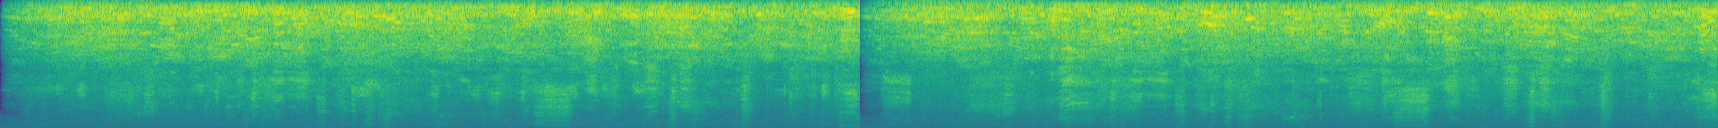

torch.Size([1, 128, 1718])

In [48]:
tensor_to_img(spectro)

## Time Warp

Time Warp is described as:
> Time warping is applied via the function sparse image warp of tensorflow. Given a log mel spectrogram with τ time steps, we view it as an image where the time axis is horizontal and the frequency axis is vertical. A random point along the horizontal line passing through the center of the image within the time steps (W, τ − W) is to be warped either to the left or right by a distance w chosen from a uniform distribution from 0 to the time warp parameter W along that line.

Intuitively we squish/stretch the audio in a given direction bounded by the `W` parameter we select.

NOTE:
`sparse_image_warp` does not exist in Pytorch, so you can see our implementation in the SparseImageWarp.ipynb notebook. Our implementation skips certain features like add clamping.

You should be careful with your `W` parameter because it's highly dependent on your audio and spectrogram. 

*Sanity check your spectrograms if you're using this transform.*

In [60]:
import random

In [61]:
def time_warp(spec, W=5):
    num_rows = spec.shape[1]
    spec_len = spec.shape[2]
    
    y = num_rows//2
    horizontal_line_at_ctr = spec[0][y]
    assert len(horizontal_line_at_ctr) == spec_len
    
    point_to_warp = horizontal_line_at_ctr[random.randrange(W, spec_len - W)]     
    assert isinstance(point_to_warp, torch.Tensor)

    # Uniform distribution from (0,W) with chance to be up to W negative
    dist_to_warp = random.randrange(-W, W)
    src_pts, dest_pts = torch.tensor([[[y, point_to_warp]]]), torch.tensor([[[y, point_to_warp + dist_to_warp]]])
    warped_spectro, dense_flows = sparse_image_warp(spec, src_pts, dest_pts)
    return warped_spectro.squeeze(3)

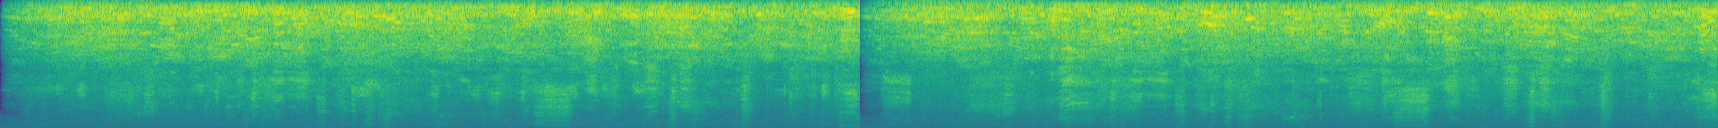

torch.Size([1, 128, 1718])

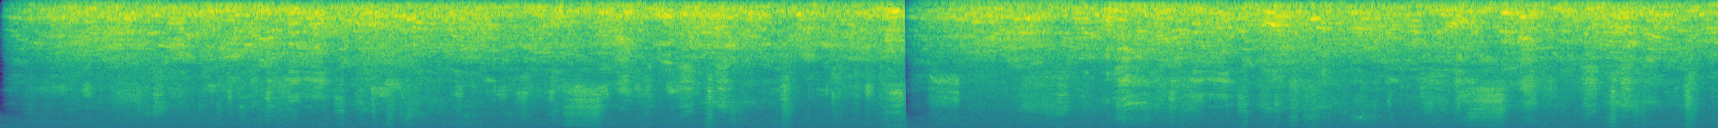

torch.Size([1, 128, 1718])

In [62]:
def test_time_warp():
    tensor_to_img(time_warp(spectro))
tensor_to_img(spectro)    
test_time_warp()

## Frequency Mask

Frequency masking is described as:
> Frequency masking is applied so that f consecutive mel
frequency channels [f0, f0 + f) are masked, where f is first chosen from a uniform distribution from 0 to the frequency mask parameter F, and f0 is chosen from 0, ν − f). ν is the number of mel frequency channels.

Intuitively, this is similar to cutout in computer vision workflows. We mask certain frequency bands with either the mean value of the spectrogram or zero.

In [63]:
def freq_mask(spec, F=30, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    num_mel_channels = cloned.shape[1]
    
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero): cloned[0][f_zero:mask_end] = 0
        else: cloned[0][f_zero:mask_end] = cloned.mean()
    
    return cloned

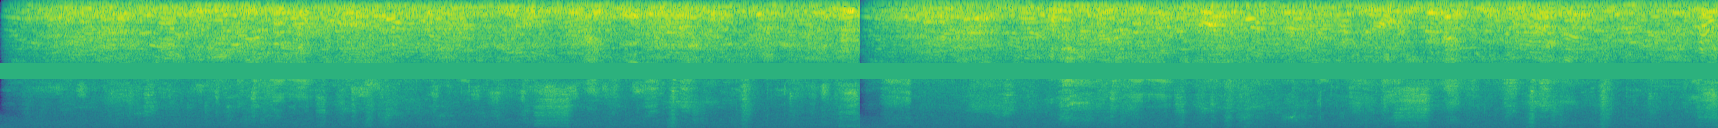

torch.Size([1, 128, 1718])

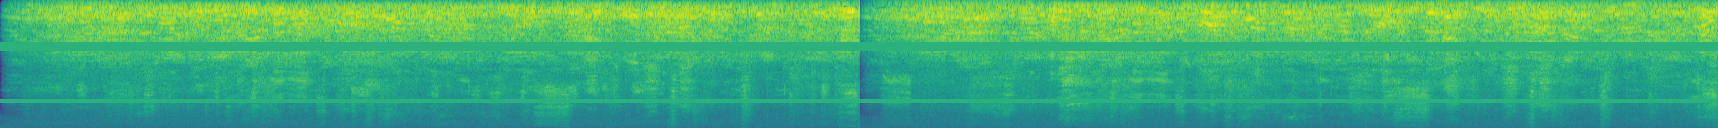

torch.Size([1, 128, 1718])

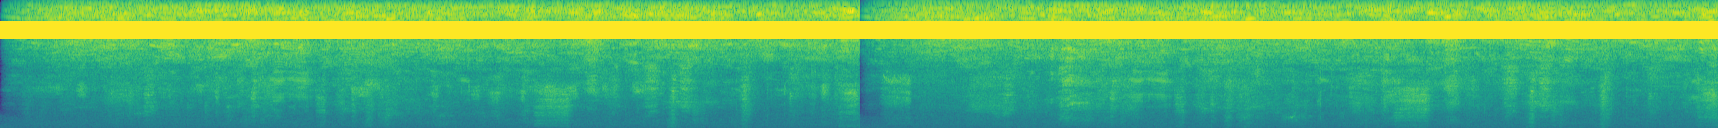

torch.Size([1, 128, 1718])

In [66]:
def test_freq_mask():
    tensor_to_img(freq_mask(spectro))
    # Two Masks...
    tensor_to_img(freq_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(freq_mask(spectro, num_masks=2, replace_with_zero=True))
test_freq_mask()

## Time Mask

Time masking is described as:
> Time masking is applied so that t consecutive time steps
[t0, t0 + t) are masked, where t is first chosen from a uniform distribution from 0 to the time mask parameter T, and t0 is chosen from [0, τ − t). We introduce an upper bound on the time mask so that a time mask cannot be wider than p times the number of time steps.

Intuitively, this is similar to cutout and the frequency mask above. We mask certain time ranges with the mean value of the spectrogram or zero.

In [72]:
def time_mask(spec, T=40, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    len_spectro = cloned.shape[2]
    
    for i in range(0, num_masks):        
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero): cloned[0][:,t_zero:mask_end] = 0
        else: cloned[0][:,t_zero:mask_end] = cloned.mean()
    return cloned

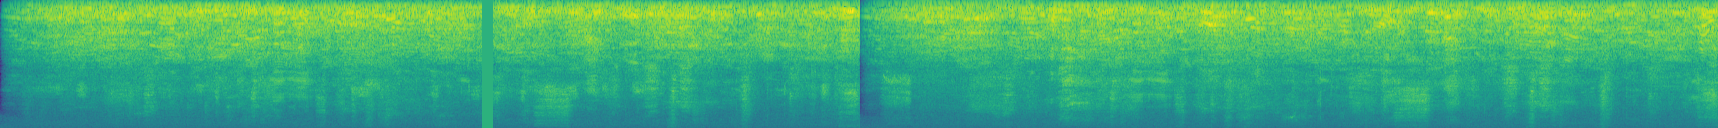

torch.Size([1, 128, 1718])

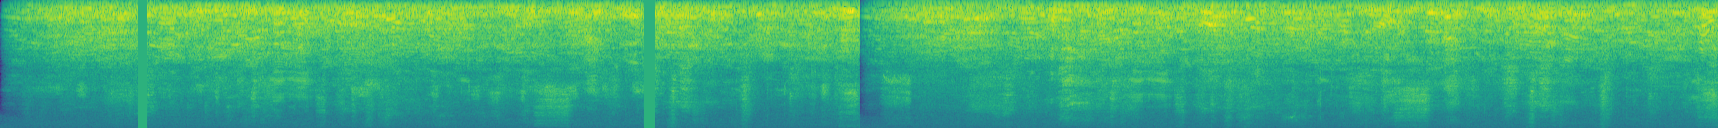

torch.Size([1, 128, 1718])

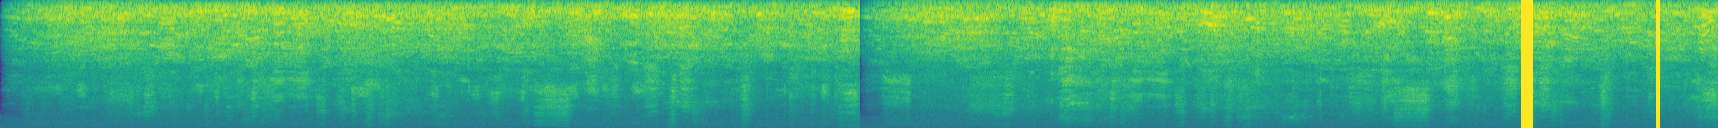

torch.Size([1, 128, 1718])

In [75]:
def test_time_mask():
    tensor_to_img(time_mask(spectro))
    # Two Masks...
    tensor_to_img(time_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(time_mask(spectro, num_masks=2, replace_with_zero=True))
test_time_mask()

## Combined
Here we combine all three transforms.

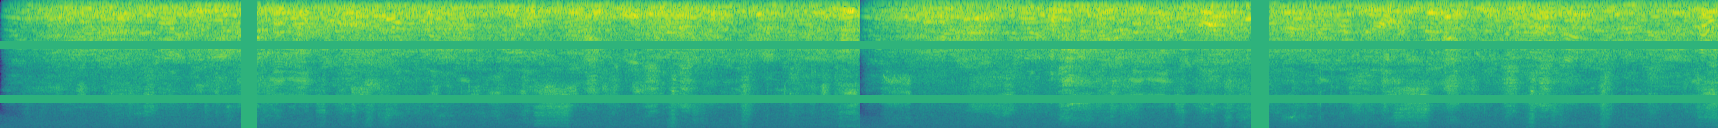

torch.Size([1, 128, 1718])

In [81]:
combined = time_mask(freq_mask(time_warp(spectro), num_masks=2), num_masks=2)
tensor_to_img(combined)

## Performance

In [82]:
%%timeit
time_warp(spectro)

27.2 ms ± 378 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [83]:
%%timeit
freq_mask(spectro)

66.3 µs ± 6.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [84]:
%%timeit
time_mask(spectro)

52.7 µs ± 1.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
